In [15]:
# Step 1: Data Exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

In [16]:
# Load dataset
df = pd.read_csv("bitcoin.csv")

# Convert Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Basic info
print(df.info())
display(df.describe())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2713 entries, 0 to 2712
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2713 non-null   datetime64[ns]
 1   Open       2713 non-null   float64       
 2   High       2713 non-null   float64       
 3   Low        2713 non-null   float64       
 4   Close      2713 non-null   float64       
 5   Adj Close  2713 non-null   float64       
 6   Volume     2713 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 148.5 KB
None


,Date,Open,High,Low,Close,Adj Close,Volume
count,2713,2713.000000,2713.000000,2713.000000,2713.000000,2713.000000,2.713000e+03
mean,2018-06-04 00:00:00.000000256,11311.041069,11614.292482,10975.555057,11323.914637,11323.914637,1.470462e+10
min,2014-09-17 00:00:00,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,2016-07-26 00:00:00,606.396973,609.260986,604.109985,606.718994,606.718994,7.991080e+07
50%,2018-06-04 00:00:00,6301.569824,6434.617676,6214.220215,6317.609863,6317.609863,5.098183e+09
75%,2020-04-12 00:00:00,10452.399414,10762.644531,10202.387695,10462.259766,10462.259766,2.456992e+10
max,2022-02-19 00:00:00,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11
std,NaN,16106.428891,16537.390649,15608.572560,16110.365010,16110.365010,2.001627e+10


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100



Missing values:
 Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


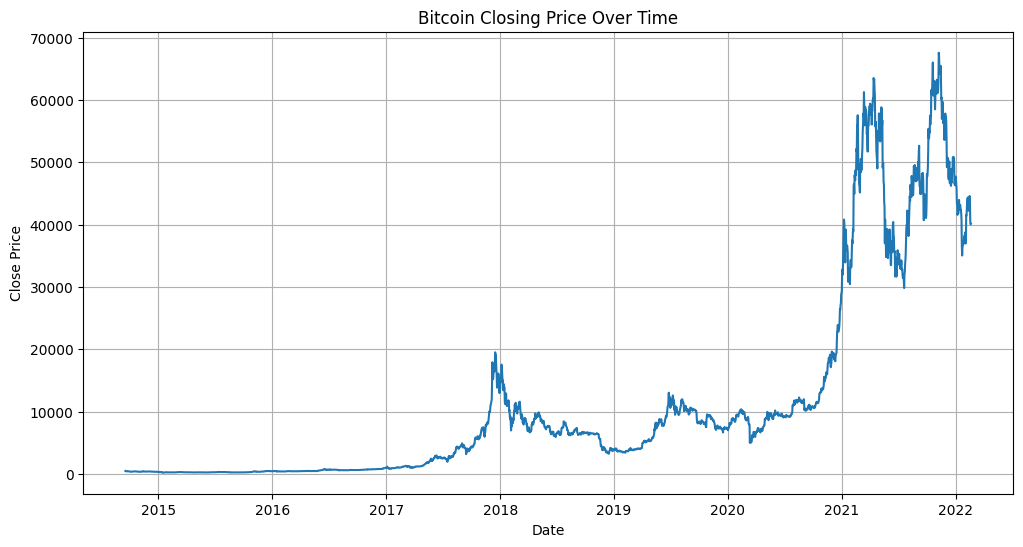

In [17]:
# Check for missing values
print("\nMissing values:\n", df.isnull().sum())

# Plot price trends
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'])
plt.title('Bitcoin Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

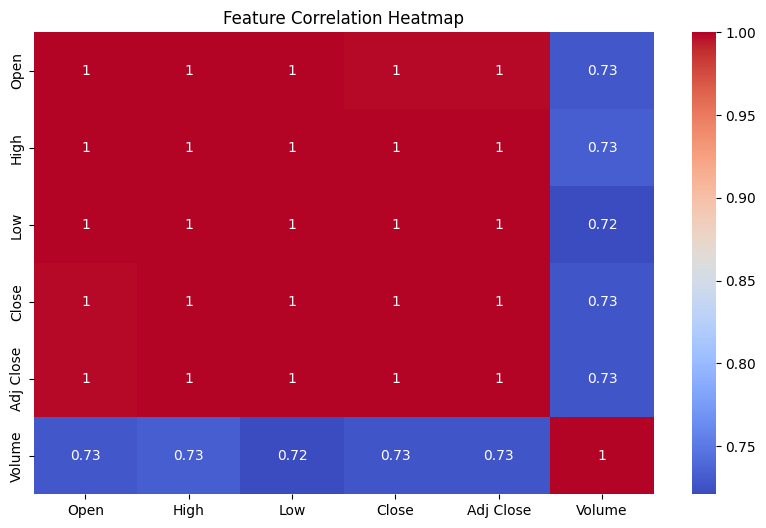

In [18]:
# Additional Visualizations
# Correlation heatmap
# Dropping Date for correlation calculation as it's not a numerical feature
plt.figure(figsize=(10, 6))
sns.heatmap(df.drop(columns=['Date']).corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


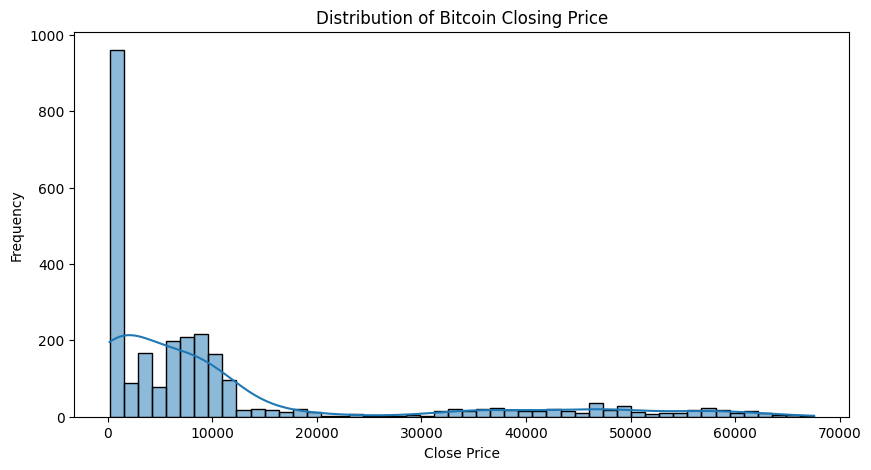

In [19]:
# Distribution of closing price
plt.figure(figsize=(10, 5))
sns.histplot(df['Close'], bins=50, kde=True)
plt.title('Distribution of Bitcoin Closing Price')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.show()

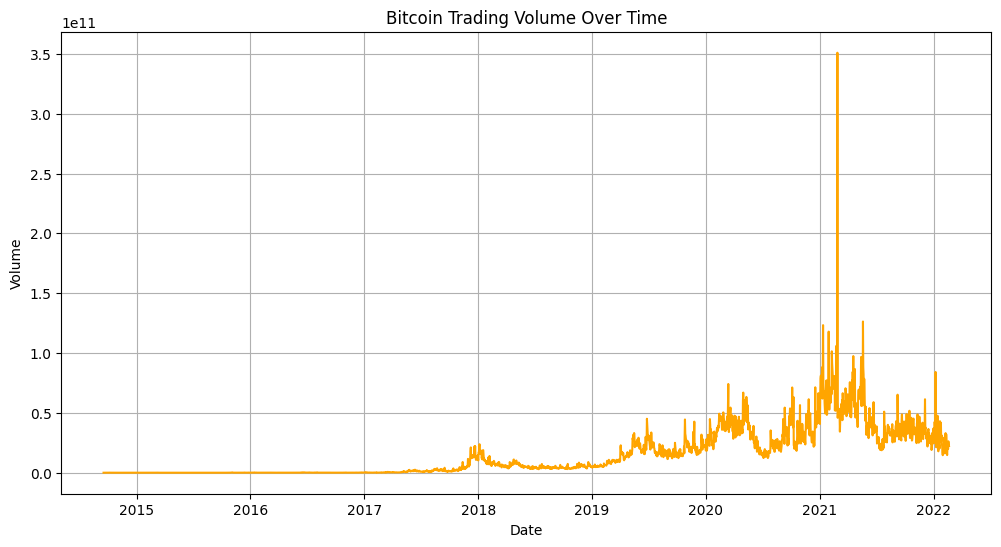

In [20]:
#Volume over time
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Volume'], color='orange')
plt.title('Bitcoin Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.show()

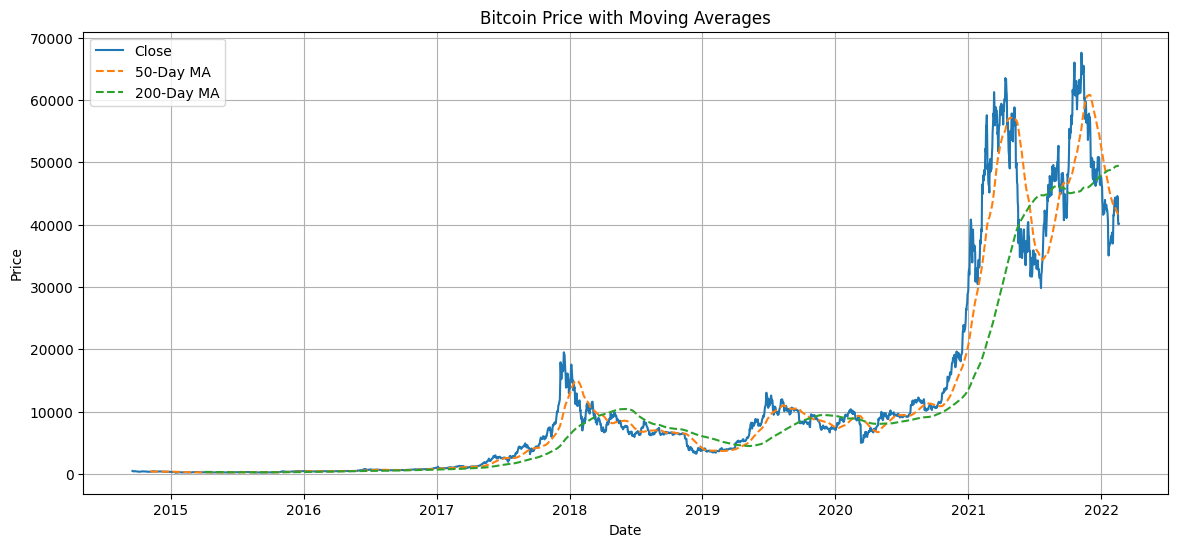

In [21]:
# Moving Averages
plt.figure(figsize=(14, 6))
df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()
plt.plot(df['Date'], df['Close'], label='Close')
plt.plot(df['Date'], df['MA50'], label='50-Day MA', linestyle='--')
plt.plot(df['Date'], df['MA200'], label='200-Day MA', linestyle='--')
plt.title('Bitcoin Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# Candlestick Plot
fig = go.Figure(data=[
    go.Candlestick(x=df['Date'],
                   open=df['Open'],
                   high=df['High'],
                   low=df['Low'],
                   close=df['Close'])
])
fig.update_layout(title='Bitcoin Candlestick Chart', xaxis_title='Date', yaxis_title='Price')
fig.show()



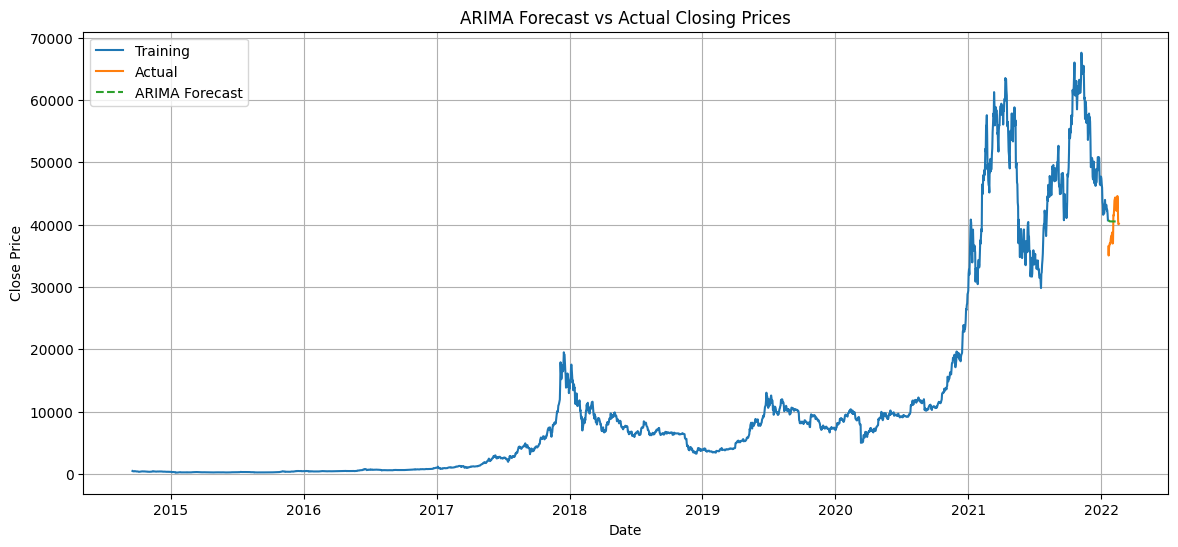

In [23]:
# ARIMA Forecasting
arima_df = df[['Date', 'Close']].set_index('Date')
train_arima = arima_df.iloc[:-30]
test_arima = arima_df.iloc[-30:]

# Ensure statsmodels is installed for ARIMA
try:
    from statsmodels.tsa.arima.model import ARIMA
except ImportError:
    print("statsmodels not found. Installing...")
    !pip install statsmodels
    from statsmodels.tsa.arima.model import ARIMA


model_arima = ARIMA(train_arima, order=(5, 1, 0))
# Adding a check for convergence if needed, but the error is before fitting
model_arima_fit = model_arima.fit()
forecast_arima = model_arima_fit.forecast(steps=30)

# Plot forecast
plt.figure(figsize=(14, 6))
plt.plot(train_arima.index, train_arima['Close'], label='Training')
plt.plot(test_arima.index, test_arima['Close'], label='Actual')
plt.plot(test_arima.index, forecast_arima, label='ARIMA Forecast', linestyle='--')
plt.title('ARIMA Forecast vs Actual Closing Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


In [24]:
# Step 2: Feature Engineering (for Regression Models)
# Create a copy of the DataFrame for regression models to avoid modifying the one used for ARIMA
df_regression = df.copy()

# Drop 'Adj Close' if it's the same as 'Close'
# Assuming 'Adj Close' is not needed for the regression models
if 'Adj Close' in df_regression.columns:
    df_regression = df_regression.drop(columns=['Adj Close'])

# Extract date features
df_regression['Year'] = df_regression['Date'].dt.year
df_regression['Month'] = df_regression['Date'].dt.month
df_regression['Day'] = df_regression['Date'].dt.day

# Drop rows with NaN values (introduced by moving averages)
df_regression.dropna(inplace=True)

# Drop the original 'Date' column now that features are extracted
df_regression = df_regression.drop(columns=['Date'])

# Check for missing values after dropping rows
print("\nMissing values after dropping rows with NaNs:\n", df_regression.isnull().sum())
print("\nShape of df_regression after dropping NaNs:", df_regression.shape)


# Define features and target
X = df_regression.drop(columns=['Close'])
y = df_regression['Close']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



Missing values after dropping rows with NaNs:
 Open      0
High      0
Low       0
Close     0
Volume    0
MA50      0
MA200     0
Year      0
Month     0
Day       0
dtype: int64

Shape of df_regression after dropping NaNs: (2514, 10)


In [26]:
# Step 3: Model Selection
# We'll evaluate Linear Regression, Random Forest, and XGBoost

# Step 4: Model Training
# Ensure the split is performed on the data after dropping NaNs
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    # Corrected the objective function name
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42)
}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Evaluation:")
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("R^2:", r2_score(y_test, y_pred))


Training Linear Regression...
Linear Regression Evaluation:
MAE: 138.03218866451186
MSE: 125526.98305246723
RMSE: 354.2978733389
R^2: 0.9995026224401579

Training Random Forest...
Random Forest Evaluation:
MAE: 204.7560861829219
MSE: 236454.18652193973
RMSE: 486.265551444825
R^2: 0.9990630938189794

Training XGBoost...
XGBoost Evaluation:
MAE: 237.13211596681046
MSE: 312069.51704256673
RMSE: 558.6318260201139
R^2: 0.9987634819931676


In [27]:
# Step 5: Cross-validation (Example for best model - XGBoost assumed best)
# Ensure cross-validation is done on the data after dropping NaNs
print("\nPerforming Cross-validation for XGBoost...")
scores = cross_val_score(models['XGBoost'], X_scaled, y, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for XGBoost:", np.sqrt(-scores).mean())


Performing Cross-validation for XGBoost...
Cross-validation RMSE for XGBoost: 6160.528154549759


In [28]:
# Step 6: Hyperparameter Tuning (Example: Random Forest)
print("\nPerforming Hyperparameter Tuning for Random Forest...")
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None]
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error')
# Fit GridSearchCV on the training data after scaling
grid_search.fit(X_train, y_train)

print("\nBest parameters from GridSearchCV:", grid_search.best_params_)
best_rf = grid_search.best_estimator_


Performing Hyperparameter Tuning for Random Forest...

Best parameters from GridSearchCV: {'max_depth': None, 'n_estimators': 200}


In [29]:
# Step 7: Final Model Evaluation
print("\nEvaluating Final Model (Tuned Random Forest)...")
final_pred = best_rf.predict(X_test)
print("Final Model (Tuned Random Forest) Evaluation:")
print("MAE:", mean_absolute_error(y_test, final_pred))
print("MSE:", mean_squared_error(y_test, final_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, final_pred)))
print("R^2:", r2_score(y_test, final_pred))


Evaluating Final Model (Tuned Random Forest)...
Final Model (Tuned Random Forest) Evaluation:
MAE: 204.2469413673549
MSE: 235041.83880772683
RMSE: 484.81113725627927
R^2: 0.9990686899867727
